In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
!pip install patchify
!pip install segmentation-models


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import random
import json
import segmentation_models as sm
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#PART 2
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



Segmentation Models: using `tf.keras` framework.


In [4]:
dire = "Dataset"

In [5]:
image_patch_size = 256

In [6]:
image_dataset = []
mask_dataset = []
for tile_id in range(1,7):
    for image_id in range(1,20):
        image = cv2.imread(f'{dire}/Tile {tile_id}/images/image_part_00{image_id}.jpg',1)
        mask = cv2.imread(f'{dire}/Tile {tile_id}/masks/image_part_00{image_id}.png',1)

        if image is not None:

            size_x = (image.shape[1]//image_patch_size)*image_patch_size
            size_y = (image.shape[0]//image_patch_size)*image_patch_size

            image = Image.fromarray(image)
            image = image.crop((0,0,size_x,size_y))
            image = np.array(image)
            patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)

            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_image = patched_images[i,j,:,:]

                    individual_image = MinMaxScaler().fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)
                    individual_image = individual_image[0]

                    image_dataset.append(individual_image)

            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, size_x, size_y))
            mask = np.array(mask)
            patched_masks = patchify(mask, (image_patch_size, image_patch_size, 3), step=image_patch_size)

            for i in range(patched_masks.shape[0]):
                for j in range(patched_masks.shape[1]):

                    individual_mask = patched_masks[i, j, :, :]
                    #individual_mask = MinMaxScaler().fit_transform(individual_mask.reshape(-1, individual_mask.shape[-1])).reshape(individual_mask.shape)
                    individual_mask = individual_mask[0]

                    mask_dataset.append(individual_mask)



In [7]:
print(len(image_dataset))
print(len(mask_dataset))

441
441


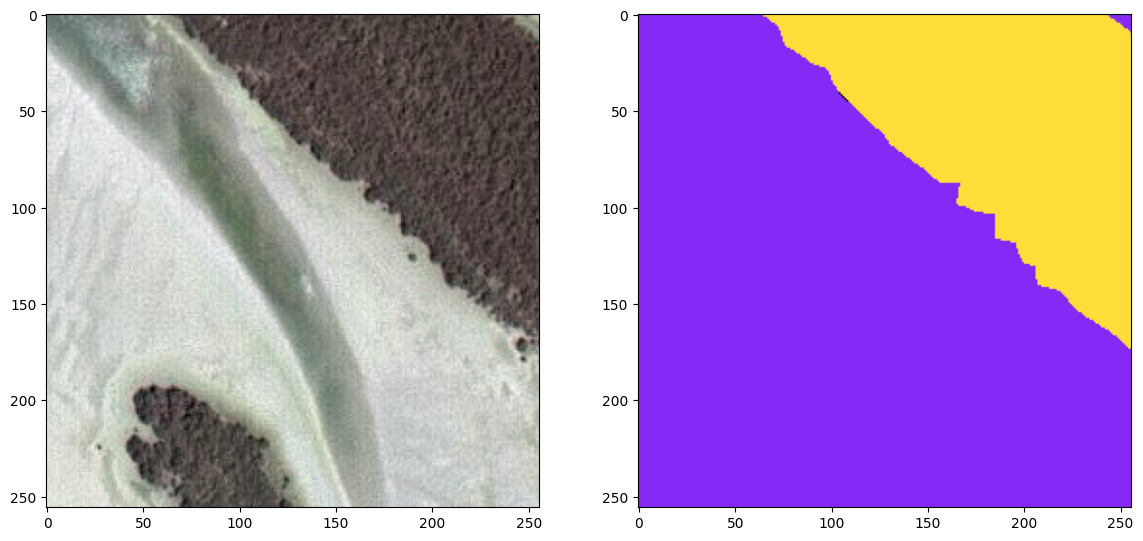

In [8]:
random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])


In [9]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [10]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [11]:
mask_dataset_np = np.array(mask_dataset)
image_dataset_np = np.array(image_dataset)
labels = []
for i in range(mask_dataset_np.shape[0]):
  label = rgb_to_label(mask_dataset_np[i])
  labels.append(label)

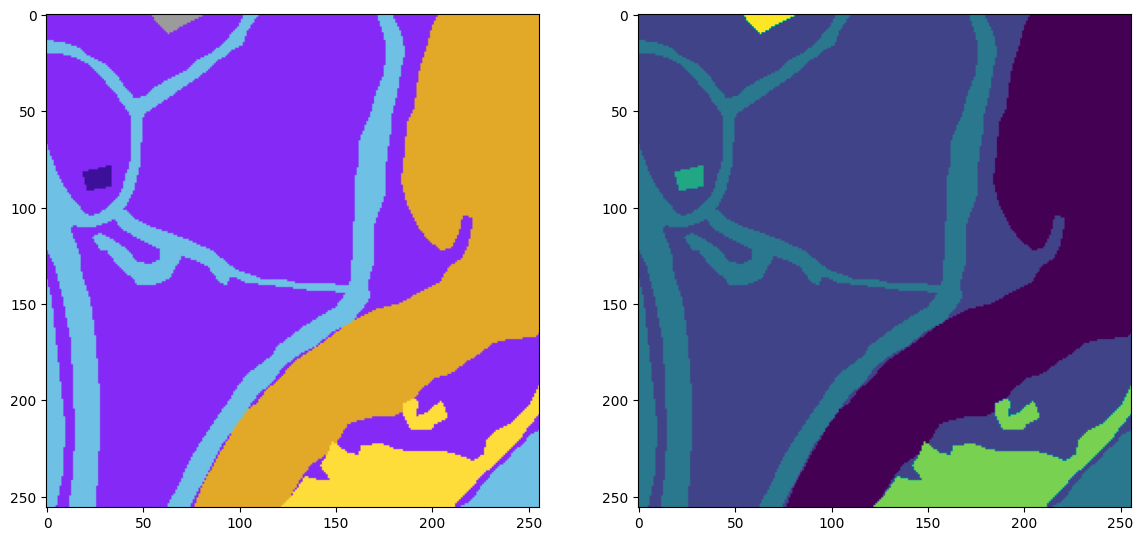

In [12]:
#np.expand_dims(labels,axis=3)

random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(mask_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id])


In [13]:
total_classes = 6

In [14]:
#One hot encoded dataset
#For each pixel its label is represented as an array ex 3 is [0 0 1 0 0 0]
# 5 is [0 0 0 0 1 0]
labels_catagorical_dataset = to_categorical(labels,num_classes = total_classes)

In [15]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset_np,labels_catagorical_dataset,test_size=0.2,random_state=100)

In [16]:
def jaccard_coef(y_true,y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat*y_pred_flat)
    final_coef_value = (intersection +1.0)/(tf.keras.backend.sum(y_true_flat)+tf.keras.backend.sum(y_pred_flat)-intersection+1.0)
    return final_coef_value

In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming your data and preprocessing remain the same

def yolo_semantic_segmentation(input_shape, num_classes):
    # Define YOLO-like architecture for semantic segmentation
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    
    # Bilinear interpolation to adjust spatial dimensions
    x = Lambda(lambda image: tf.image.resize(image, (input_shape[0], input_shape[1])))(x)
    
    # Adjusting channel dimensions
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

# Define YOLO parameters
input_shape = (256, 256, 3)  # Example input shape
num_classes = total_classes  # Same as total_classes in your code

# Create YOLO-based semantic segmentation model
yolo_model = yolo_semantic_segmentation(input_shape, num_classes)

# Compile the model
yolo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
yolo_model.summary()





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        184

In [18]:
# Train the model
yolo_history = yolo_model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/100


22/22 [==============================] - 75s 3s/step - loss: 1.5727 - accuracy: 0.3847 - val_loss: 1.4870 - val_accuracy: 0.3526
Epoch 2/100
22/22 [==============================] - 59s 3s/step - loss: 1.4242 - accuracy: 0.4097 - val_loss: 1.4748 - val_accuracy: 0.5848
Epoch 3/100
22/22 [==============================] - 65s 3s/step - loss: 1.1972 - accuracy: 0.5950 - val_loss: 1.0274 - val_accuracy: 0.6244
Epoch 4/100
22/22 [==============================] - 73s 3s/step - loss: 1.0466 - accuracy: 0.6193 - val_loss: 0.9298 - val_accuracy: 0.6408
Epoch 5/100
22/22 [==============================] - 124s 6s/step - loss: 1.0491 - accuracy: 0.6204 - val_loss: 1.2249 - val_accuracy: 0.5961
Epoch 6/100
22/22 [==============================] - 114s 5s/step - loss: 1.1127 - accuracy: 0.6143 - val_loss: 1.0499 - val_accuracy: 0.6194
Epoch 7/100
15/22 [===================>..........] - ETA: 22s - loss: 1.0118 - accuracy: 0.6269

: 

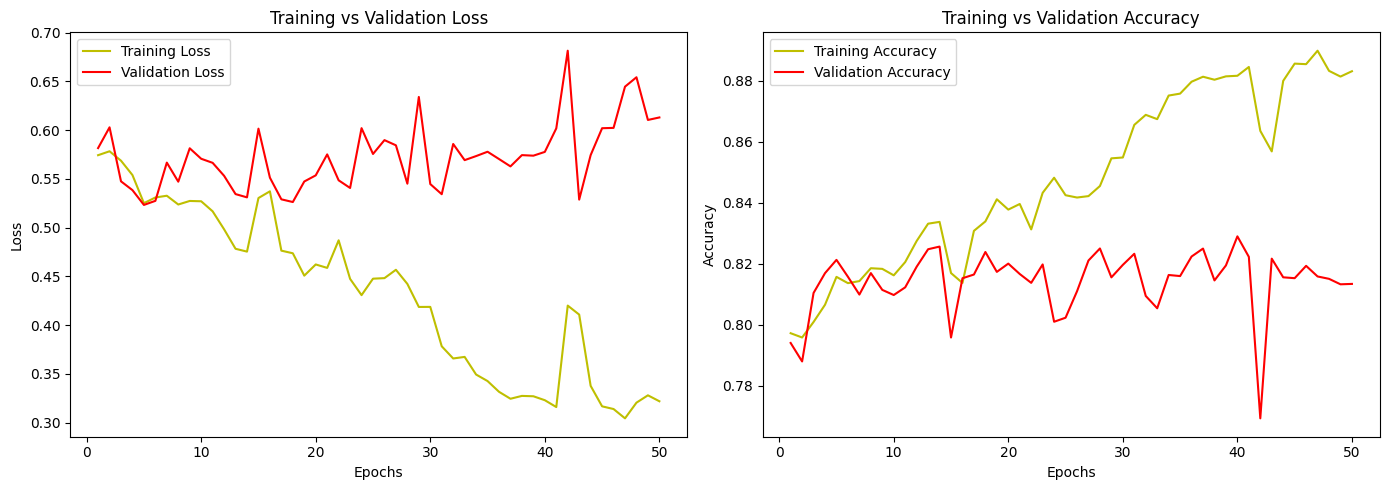

In [ ]:
# Plot training and validation loss
loss = yolo_history.history['loss']
val_loss = yolo_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
acc = yolo_history.history['accuracy']
val_acc = yolo_history.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on test data
y_pred = yolo_model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 [==============================] - 2s 323ms/step


1/1 [==============================] - 0s 35ms/step


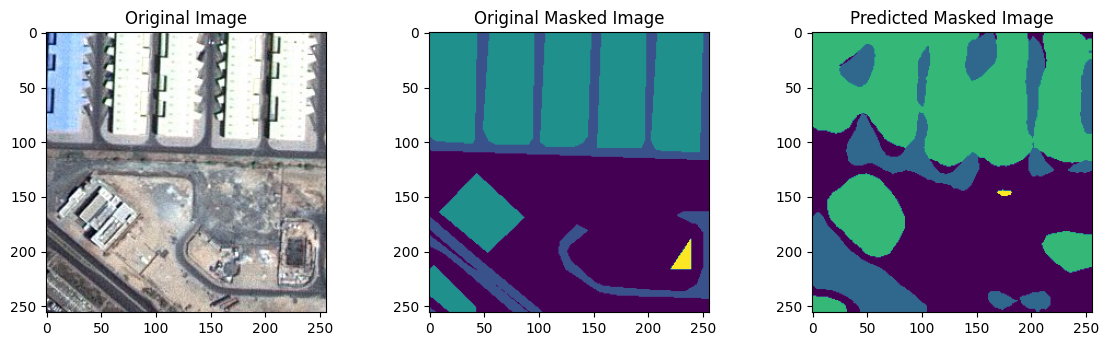

In [ ]:
# Comparing Results
test_image_number = random.randint(0, len(y_pred_label))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = yolo_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0, :, :]

plt.figure(figsize=(14, 8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)

plt.subplot(232)
plt.title('Original Masked Image')
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title('Predicted Masked Image')
plt.imshow(predicted_image)
plt.show()

In [ ]:
type(predicted_image)

numpy.ndarray

In [ ]:
# Save the model
yolo_model.save("YOLO.h5")

C:\Users\barde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
